# CS4120 Final Project
### Junhao Lin, Xianrui She

### 1. Data Display & Preprocessing

In [11]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

#### 1.1 Data Display

In [38]:
# reading the data
train = pd.read_csv('./data/train.csv')

In [3]:
# data preview
train

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


#### 1.2 Class Balance

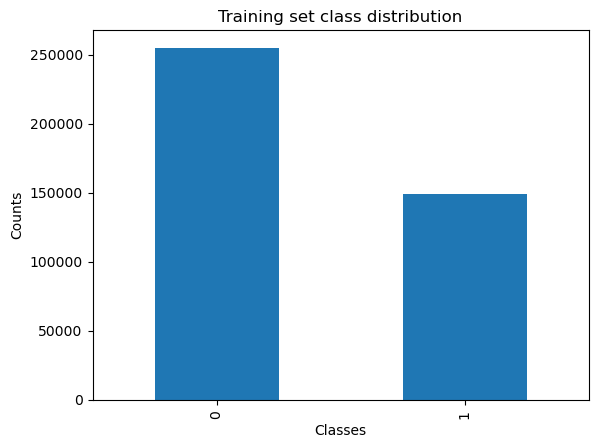

In [5]:
train['is_duplicate'].value_counts().plot.bar()
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Training set class distribution')
plt.show()

In [39]:
# cropping the training data so that classes are balanced (50/50)
min_length = len(train[train['is_duplicate']  == 1])
train_0_balanced = train[train['is_duplicate']  == 0].sample(min_length, random_state=42)

# use 1/5 of the available training data due to hardware limitation
train_balanced = pd.concat([train_0_balanced[:min_length // 5], train[train['is_duplicate']  == 1][:min_length // 5]])

In [40]:
# check and drop any NAs
train_balanced.isna().sum()
train_balanced.dropna(inplace=True)

#### 1.3 Normalization and Tokenization

In [8]:
def normalize(text:str) -> list:
    ''' Function to normalize and tokenize our data correctly

    - input: text(str), unprocessed question as a string
    - output: result(list), processed tokens as a list of strings
    '''
    # replace some currency characters into words
    text = text.replace('%', ' percent ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('¥', ' yuan ')

    # the pattern '[math]' appears around 900 times in the whole dataset.
    text = text.replace('[math]', '')
    
    # replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    text = text.replace(',000,000,000 ', 'b ')
    text = text.replace(',000,000 ', 'm ')
    text = text.replace(',000 ', 'k ')
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)

    # convert all stemmed words to its original form
    stemmer = SnowballStemmer('english')
    tokens = word_tokenize(text)

    for i in range(len(tokens)):
        tokens[i] = stemmer.stem(tokens[i])
    
    return ' '.join(tokens)

In [9]:
# tokenize sentences in training data 
train_q1 = list(train_balanced['question1'].apply(normalize))
train_q2 = list(train_balanced['question2'].apply(normalize))

#### 1.4 Vectorization

In [12]:
vectorizer = CountVectorizer()
q1_vec = vectorizer.fit_transform(train_q1)
q2_vec = vectorizer.fit_transform(train_q2)

In [13]:
# horizontally combine the two question matrices
X = hstack((q1_vec, q2_vec))

### 2. Logistic Regression

In [14]:
# import libraries for this section
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [15]:
# train-test split
X_train, X_test, y_train,y_test = train_test_split(X, train_balanced['is_duplicate'], test_size=0.2, random_state=42)

#### 2.1 Building Model

In [30]:
# build the baseline model
model_base = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, n_jobs=4, alpha=0.00001, early_stopping=True, random_state=1)
model_base.fit(X_train,y_train)
y_pred = model_base.predict(X_test)
print('The accuracy for baseline logistic regression:', accuracy_score(y_test, y_pred))

The accuracy for baseline logistic regression: 0.669960639812411


#### 2.2 Gridsearch

In [20]:
# search for best hyperparameter combination
params = {'penalty':['l1', 'l2'], 'tol':[1e-3, 1e-4, 1e-5], 'alpha':[0.0001, 0.005, 0.001]}
sgd = SGDClassifier(loss='log_loss', max_iter=1000, n_jobs=4, early_stopping=True)
grid = GridSearchCV(sgd, params)
grid.fit(X_train,y_train)

GridSearchCV(estimator=SGDClassifier(early_stopping=True, loss='log_loss',
                                     n_jobs=4),
             param_grid={'alpha': [0.0001, 0.005, 0.001],
                         'penalty': ['l1', 'l2'],
                         'tol': [0.001, 0.0001, 1e-05]})

In [21]:
# display the best parameter values
best_params = grid.best_params_
best_params

{'alpha': 0.001, 'penalty': 'l2', 'tol': 1e-05}

In [31]:
# use the results of grid search and re-fit the model
model_improve = SGDClassifier(loss='log_loss', max_iter=1000, tol=best_params['tol'], n_jobs=4, alpha=best_params['alpha'], penalty='l2', early_stopping=True, random_state=1)
model_improve.fit(X_train,y_train)
y_pred = model_improve.predict(X_test)
print('The accuracy for improved logistic regression:', accuracy_score(y_test, y_pred))

The accuracy for improved logistic regression: 0.6936604974457751


#### 2.3 Classification Threshold

In [32]:
# experiment on what determination threshold produces the best performance
y_pred_prob = model_improve.predict_proba(X_test)
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for i in thresholds:
    y_pred = [1 if y_hat_val[1] > i else 0 for y_hat_val in y_pred_prob]
    print(f'Accuracy for threshold = {i}:', accuracy_score(y_test,y_pred))

Accuracy for threshold = 0.3: 0.619378611506574
Accuracy for threshold = 0.4: 0.6705468553722469
Accuracy for threshold = 0.5: 0.6936604974457751
Accuracy for threshold = 0.6: 0.6728917176115903
Accuracy for threshold = 0.7: 0.6076543003098568


#### 2.4 Confusion Matrix

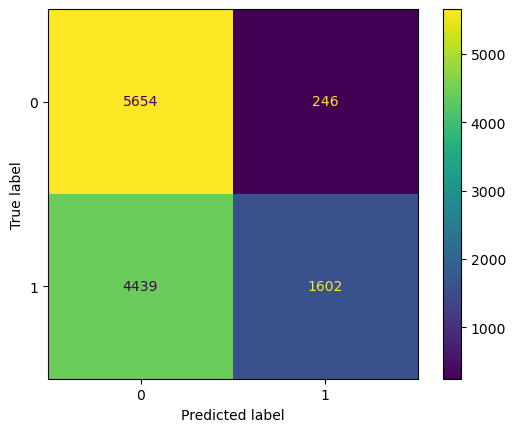

In [34]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_improve.classes_)
disp.plot()
plt.show()

### 3. RNN with GloVe Embeddings and LSTM

In [64]:
# import libraries for this section
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Multiply, Flatten
from tensorflow.keras.layers import LSTM

In [46]:
# sample the data to reduce training time (to about 1/4 of the total size)
df = train.sample(100000)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 3:5].values, df['is_duplicate'].values, test_size=0.2, random_state=42)

In [51]:
# extract each question from the training and test sets
train_q1 = X_train[:,0]
train_q2 = X_train[:,1]

test_q1 = X_test[:,0]
test_q2 = X_test[:,1]

#### 3.1 Tokenization and Encoding

In [53]:
# training the keras tokenizer
MAX_NB_WORDS = 200000
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(list(df['question1'].values.astype(str))+list(df['question2'].values.astype(str)))

In [57]:
# encode each token into an int and pad them to equal-length sequences
X_train_q1 = tokenizer.texts_to_sequences(train_q1)
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding='post')

X_train_q2 = tokenizer.texts_to_sequences(train_q2)
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding='post')

X_test_q1 = tokenizer.texts_to_sequences(test_q1)
X_test_q1 = pad_sequences(X_test_q1, maxlen = 30, padding='post')

X_test_q2 = tokenizer.texts_to_sequences(test_q2)
X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')

In [58]:
word_index = tokenizer.word_index

#### 3.2 Load GloVe Embeddings

In [59]:
# read the pre-trained GloVe embeddings with 200 dimensions
embedding_index = {}
with open('glove.6B.200d.txt','r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_index[word] = vectors
    f.close()

In [60]:
# load the embeddings into a matrix
embedding_matrix = np.random.random((len(word_index)+1, 200))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### 3.3 Building Model

In [61]:
# Model for question 1
model_q1 = Sequential()
model_q1.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 200,
                      weights = [embedding_matrix],
                      input_length = 30))
model_q1.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q1.add(Dropout(0.2))
model_q1.add(LSTM(128, return_sequences = True))
model_q1.add(LSTM(128))
model_q1.add(Dense(60, activation = 'tanh'))
model_q1.add(Dense(2, activation = 'sigmoid'))

In [62]:
# Model for question 2
model_q2 = Sequential()
model_q2.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 200,
                      weights = [embedding_matrix],
                      input_length = 30))
model_q2.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q2.add(Dropout(0.2))
model_q2.add(LSTM(128, return_sequences = True))
model_q2.add(LSTM(128))
model_q2.add(Dense(60, activation = 'tanh'))
model_q2.add(Dense(2, activation = 'sigmoid'))

In [65]:
# combine q1 and q2 models
model_combined = Multiply()([model_q1.output, model_q2.output])
model_combined = Flatten()(model_combined)
model_combined = Dense(100, activation = 'relu')(model_combined)
model_combined = Dropout(0.2)(model_combined)
model_combined = Dense(50, activation = 'relu')(model_combined)
model_combined = Dropout(0.2)(model_combined)
model_combined = Dense(2, activation = 'sigmoid')(model_combined)

In [66]:
new_model = Model([model_q1.input, model_q2.input], model_combined)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
history = new_model.fit([X_train_q1, X_train_q2], y_train, batch_size = 2000, epochs = 10)

Epoch 1/10
40/40 [==============================] - 346s 8s/step - loss: 0.6532 - accuracy: 0.6288
Epoch 2/10
40/40 [==============================] - 347s 9s/step - loss: 0.6182 - accuracy: 0.6314
Epoch 3/10
40/40 [==============================] - 391s 10s/step - loss: 0.5825 - accuracy: 0.6886
Epoch 4/10
40/40 [==============================] - 419s 10s/step - loss: 0.5548 - accuracy: 0.7153
Epoch 5/10
40/40 [==============================] - 422s 11s/step - loss: 0.5218 - accuracy: 0.7421
Epoch 6/10
40/40 [==============================] - 409s 10s/step - loss: 0.4945 - accuracy: 0.7616
Epoch 7/10
40/40 [==============================] - 428s 11s/step - loss: 0.4619 - accuracy: 0.7828
Epoch 8/10
40/40 [==============================] - 392s 10s/step - loss: 0.4409 - accuracy: 0.7949
Epoch 9/10
40/40 [==============================] - 367s 9s/step - loss: 0.4107 - accuracy: 0.8116
Epoch 10/10
40/40 [==============================] - 364s 9s/step - loss: 0.3849 - accuracy: 0.8264


In [70]:
y_pred =  new_model.predict([X_test_q1, X_test_q2], batch_size=2000, verbose=1)
y_pred = [1 if pred[1] > pred[0] else 0 for pred in y_pred]
print('The accuracy for LSTM:', accuracy_score(y_test, y_pred))

10/10 [==============================] - 16s 2s/step
The accuracy for LSTM: 0.72455


#### 3.4 Confusion Matrix

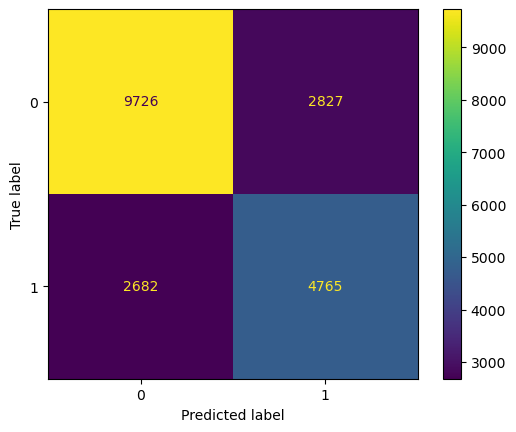

In [69]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()